# Sartorius 

Dit is een onderzoek naar het autmoatiseren van de annotatie op hersen cellen.
Dit onderzoek is gestart om te zorgen dat doktoren meer tijd over hebben voor andere bezigheden.

Door groep 4
Danny Rovers, Thomas Hendriks en Liam Freke

In [1]:
#pip install opencv-python

In [2]:
import pandas as pd
from warnings import filterwarnings
import tensorflow as tf
from tensorflow import io
from tensorflow import image
from matplotlib import pyplot as plt
import sys
import cv2
import seaborn as sns
import os
from tqdm.notebook import tqdm
import numpy as np
from PIL import Image as im
from PIL import ImageFilter

Als eerste wordt de data opgehaald. Wij beginnen daarmee door het csv bestandt train op te halen. Dit zie je in onderstaande code.

In [3]:
pad_naar_file = r"C:\Users\liamf\OneDrive - Hogeschool Leiden\Documenten\Northpool\Image_Processing\sartorius-cell-instance-segmentation\train.csv"
type(pad_naar_file)

str

In [4]:
def read_data(csv_file):
    dataframe = pd.read_csv(csv_file)

    #zet hier de code om de CSV file in te lezen
    return dataframe

In [5]:
#hier wordt jouw functie aangeroepen en bevat df nu het dataframe
df = read_data(pad_naar_file);

In [6]:
df

id                                         annotation  width  \
0      0030fd0e6378  118145 6 118849 7 119553 8 120257 8 120961 9 1...    704   
1      0030fd0e6378  189036 1 189739 3 190441 6 191144 7 191848 8 1...    704   
2      0030fd0e6378  173567 3 174270 5 174974 5 175678 6 176382 7 1...    704   
3      0030fd0e6378  196723 4 197427 6 198130 7 198834 8 199538 8 2...    704   
4      0030fd0e6378  167818 3 168522 5 169225 7 169928 8 170632 9 1...    704   
...             ...                                                ...    ...   
73580  ffdb3cc02eef  3610 3 4311 7 5014 9 5717 11 6420 13 7123 15 7...    704   
73581  ffdb3cc02eef  341585 2 342287 5 342988 10 343690 13 344394 1...    704   
73582  ffdb3cc02eef  47788 3 48490 7 49192 11 49896 13 50599 14 513...    704   
73583  ffdb3cc02eef  333290 1 333993 2 334696 4 335399 5 336102 6 3...    704   
73584  ffdb3cc02eef  249775 2 250477 6 251180 8 251882 11 252585 12...    704   

       height cell_type plate_time sample_date  \
0         520    shsy5y  11h30m00s  2019-06-16   
1         520    shsy5y  11h30m00s  2019-06-16   
2         520    shsy5y  11h30m00s  2019-06-16   
3         520    shsy5y  11h30m00s  2019-06-16   
4         520    shsy5y  11h30m00s  2019-06-16   
...       ...       ...        ...         ...   
73580     520      cort  11h59m00s  2020-11-01   
73581     520      cort  11h59m00s  2020-11-01   
73582     520      cort  11h59m00s  2020-11-01   
73583     520      cort  11h59m00s  2020-11-01   
73584     520      cort  11h59m00s  2020-11-01   

                                sample_id elapsed_timedelta  
0      shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
1      shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
2      shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
3      shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
4      shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
...                                   ...               ...  
73580   cort[debris]_D9-3_Vessel-384_Ph_4   0 days 11:59:00  
73581   cort[debris]_D9-3_Vessel-384_Ph_4   0 days 11:59:00  
73582   cort[debris]_D9-3_Vessel-384_Ph_4   0 days 11:59:00  
73583   cort[debris]_D9-3_Vessel-384_Ph_4   0 days 11:59:00  
73584   cort[debris]_D9-3_Vessel-384_Ph_4   0 days 11:59:00  

[73585 rows x 9 columns]

In [7]:
potlood = df.loc[df['id'] == '0030fd0e6378'].annotation.tolist()
potlood

['118145 6 118849 7 119553 8 120257 8 120961 9 121665 10 122369 12 123074 13 123778 14 124482 15 125186 16 125890 17 126594 18 127298 19 128002 20 128706 21 129410 22 130114 23 130818 24 131523 24 132227 25 132931 25 133635 24 134339 24 135043 23 135748 21 136452 19 137157 16 137864 11 138573 4',
 '189036 1 189739 3 190441 6 191144 7 191848 8 192552 9 193256 10 193960 11 194664 11 195368 12 196072 12 196776 13 197480 13 198185 13 198889 13 199593 14 200297 13 201002 11 201706 10 202410 9 203115 7 203819 6 204523 5 205227 5 205932 3 206636 2 207340 1',
 '173567 3 174270 5 174974 5 175678 6 176382 7 177085 9 177789 9 178493 10 179197 11 179901 12 180605 12 181308 14 182012 15 182716 15 183420 16 184125 16 184831 15 185536 14 186241 14 186947 12 187651 13 188356 12 189061 12 189767 10 190472 10 191177 9 191883 7 192589 5 193295 2 194000 1',
 '196723 4 197427 6 198130 7 198834 8 199538 8 200242 9 200946 9 201650 10 202354 10 203058 10 203762 11 204466 11 205170 12 205874 12 206578 13 20728

Vanuit deze tabel hebben wij een data dictionary opgesteld.

### Data dictionary ###

| Variabele | Omschrijving | Datatype | Numeriek of Categorie | Meetniveau |
| :--- | :--- | :--- | :--- | :--- |
| Id | Een unieke identificatie code | Integer | Nummeriek | Ordinaal |
| annotation | gecodeerde pixels van een geïdentificeerde neuronen cell | object | Nummeriek | Ordinaal |
| width | breedte van de source image | Integer | Nummeriek | Interval |
| height | hoogte van de source image | Integer | Nummeriek | Interval |
| cell_type | Type van de cell | String | Catagorie | Nominaal |
| plate_time | Tijd van het maken van de sample | Time | Nummeriek | Interval |
| sample_date | Datum wanneer de sample is gemaakt | Date | Nummeriek | Interval |
| sample_id | Een unieke identificatie code van de sample | Integer | Catagorie | Ordinaal |
| elepased_timedelta | Tijd sinds eerste image is genomen | Date | Nummeriek | Ratio |

## Controleren van de data

Hierboven staat een deel van de data in het train csv bestandt. De data ziet er schoon uit maar wij zullen dit eerst testen voor de zekerheid. We zullen beginnen met het kijken naar de nullwaardes.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73585 entries, 0 to 73584
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 73585 non-null  object
 1   annotation         73585 non-null  object
 2   width              73585 non-null  int64 
 3   height             73585 non-null  int64 
 4   cell_type          73585 non-null  object
 5   plate_time         73585 non-null  object
 6   sample_date        73585 non-null  object
 7   sample_id          73585 non-null  object
 8   elapsed_timedelta  73585 non-null  object
dtypes: int64(2), object(7)
memory usage: 5.1+ MB


Hierboven staat de info over de tabel. Hierin staat ook dat er geen nullwaardes bevinden in de data. Verder zien we ook dat de data types van de kolommen goed staan. We zullen nu kijken naar alle unieke catagorische data.

In [9]:
df['cell_type'].unique()

array(['shsy5y', 'astro', 'cort'], dtype=object)

In [10]:
df['plate_time'].unique()

array(['11h30m00s', '09h00m00s', '13h30m00s', '19h30m00s', '07h30m00s',
       '11h59m00s', '01h30m00s', '13h00m00s'], dtype=object)

In [11]:
df['sample_date'].unique()

array(['2019-06-16', '2020-09-13', '2020-11-04', '2020-10-27',
       '2020-11-07', '2019-06-14', '2019-06-15', '2020-11-03',
       '2020-11-06', '2020-10-30', '2020-11-05', '2020-09-15',
       '2020-09-16', '2020-09-14', '2020-09-12', '2020-10-26',
       '2020-11-01', '2020-10-29'], dtype=object)

In [12]:
df['elapsed_timedelta'].unique()

array(['0 days 11:30:00', '0 days 09:00:00', '0 days 13:30:00',
       '0 days 19:30:00', '0 days 07:30:00', '0 days 11:59:00',
       '0 days 01:30:00', '0 days 13:00:00'], dtype=object)

In [13]:
df['width'].unique()

array([704], dtype=int64)

In [14]:
df['height'].unique()

array([520], dtype=int64)

In [15]:
df["id"].value_counts(normalize=False)

c4121689002f    790
d164e96bb7a9    782
e748ac1c469b    703
aff8fb4fc364    609
e8ae919aa92e    605
               ... 
7f21996da2e6      8
c25db38e918e      6
eec79772cb99      5
b861811eaff6      5
e92c56871769      4
Name: id, Length: 606, dtype: int64

In [16]:
df["sample_id"].value_counts(normalize=False)

shsy5y[diff]_E10-3_Vessel-714_Ph_4    1463
shsy5y[diff]_D11-2_Vessel-714_Ph_3    1313
shsy5y[diff]_D11-2_Vessel-714_Ph_1    1233
shsy5y[diff]_D11-1_Vessel-714_Ph_4    1230
shsy5y[diff]_D12-4_Vessel-714_Ph_4    1181
                                      ... 
cort[density]_A9-4_Vessel-376_Ph_4      11
astro[hippo]_F3-3_Vessel-361_Ph_1       10
cort[6-OHDA]_B1-2_Vessel-377_Ph_2        9
cort[6-OHDA]_G2-1_Vessel-377_Ph_4        8
astro[hippo]_H6-4_Vessel-361_Ph_4        5
Name: sample_id, Length: 403, dtype: int64

De catagorische data toont ons hoeveel verschillende waardes voorkomen.
Nu zullen wij de waardes van "cell_type" omzetten naar getallen omdat dit beter werkbaar is voor onze analyse.
De waardes "width" en "height" hebben beide maar één waarde.
De waardes "id" komt meerdere keren voor. Dit kan omdat er op meerdere pixels op de foto's van de data set markerkingen kunnen staan.
De waarde "sample_id" komt ook meerdere keren voor. Deze waarde komt vaker voor dan "id" en geeft aan dat er waarschijnlijk van een monster meerdere foto's zijn gemaakt.
Verder zien we geen andere opmerkelijke dingen in de data staan.
De andere waardes laten wij voor nu staan.

In [17]:
def vervang_categorienaam(dataframe):
    set_wc = {'shsy5y':0,'astro':1,'cort':2}
    dataframe['cell_type'] = dataframe['cell_type'].map(set_wc)
    return dataframe

In [18]:
df = vervang_categorienaam(df)

We gaan nu verder met het bekijken van de correlaties in de data.

<AxesSubplot:>

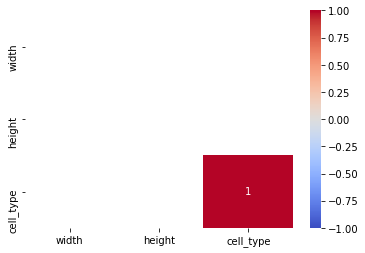

In [19]:
sns.heatmap(df.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

Hierboven staat een lege heatmap. Dit geeft aan dat er geen correlaties bevinden in de data. Nu zullen wij verder kijken naar de verdeling van de data we beginen met cell_type

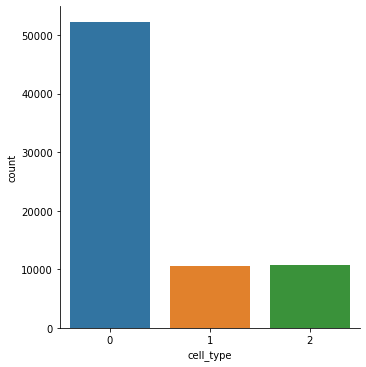

In [20]:
sns.catplot(x='cell_type', data=df,kind='count')  

Hierin valt goed te zien dat de shsy5y cell het meeste voor komt. Hierna komen de andere twee cellen die dicht bij elkaar liggen. Nu zullen we kijken naar de kolommen "elapsed_timedelta", "sample_date" en "plate_time".

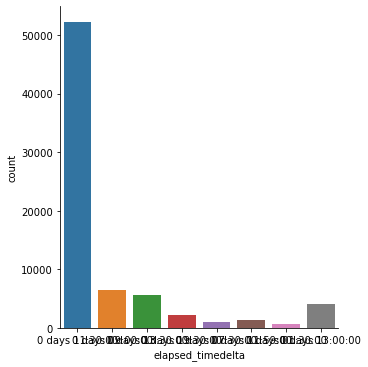

In [21]:
sns.catplot(x='elapsed_timedelta', data=df,kind='count')

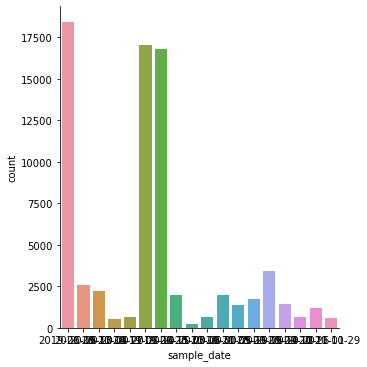

In [22]:
sns.catplot(x='sample_date', data=df,kind='count')

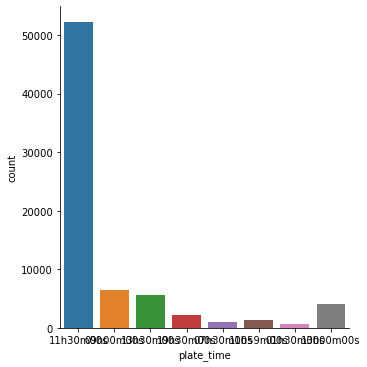

In [23]:
sns.catplot(x='plate_time', data=df,kind='count')

Bovenstaande grafieken geven aan dat de proeven of monsters vaak rond dezelfde tijd gedaan zijn. We gaan nu verder met het verwijderen van kolommen die niet nuttig zijn voor het onderzoek.

In [24]:
def verwijder(dataframe):
    dataframe = df.drop(['elapsed_timedelta'], axis=1)
    dataframe = df.drop(['sample_date'], axis=1)
    dataframe = df.drop(['plate_time'], axis=1)
    dataframe = df.drop(['width'], axis=1)
    dataframe = df.drop(['height'], axis=1)
    return dataframe

In [25]:
df = verwijder(df)

Wij hebben ervoor gekozen om de kolommen "elapsed_timedelta", "sample_date" en "plate_time" te verwijderen omdat dit tijd aangeeft. Dit hebben wij niet nodig voor oons onderzoek. 
Verder hebben wij "Width"en "height" verwijderd. Deze kolommen hebben beide maar 1 waarde en is daarom niet nuttig voor ons om mee te nemen in het onderzoek. Hieronder staat een voorbeeld van de uiteindelijke data set.

In [26]:
df.head(10)

id                                         annotation  width  \
0  0030fd0e6378  118145 6 118849 7 119553 8 120257 8 120961 9 1...    704   
1  0030fd0e6378  189036 1 189739 3 190441 6 191144 7 191848 8 1...    704   
2  0030fd0e6378  173567 3 174270 5 174974 5 175678 6 176382 7 1...    704   
3  0030fd0e6378  196723 4 197427 6 198130 7 198834 8 199538 8 2...    704   
4  0030fd0e6378  167818 3 168522 5 169225 7 169928 8 170632 9 1...    704   
5  0030fd0e6378  205984 2 206687 4 207391 5 208095 5 208799 6 2...    704   
6  0030fd0e6378  203101 2 203805 5 204509 7 205213 10 205917 12...    704   
7  0030fd0e6378  191900 2 192604 3 193308 4 194012 5 194717 5 1...    704   
8  0030fd0e6378  184848 3 185551 5 186254 7 186958 8 187662 9 1...    704   
9  0030fd0e6378  165119 1 165822 4 166526 6 167230 9 167935 9 1...    704   

   cell_type plate_time sample_date                           sample_id  \
0          0  11h30m00s  2019-06-16  shsy5y[diff]_E10-4_Vessel-714_Ph_3   
1          0  11h30m00s  2019-06-16  shsy5y[diff]_E10-4_Vessel-714_Ph_3   
2          0  11h30m00s  2019-06-16  shsy5y[diff]_E10-4_Vessel-714_Ph_3   
3          0  11h30m00s  2019-06-16  shsy5y[diff]_E10-4_Vessel-714_Ph_3   
4          0  11h30m00s  2019-06-16  shsy5y[diff]_E10-4_Vessel-714_Ph_3   
5          0  11h30m00s  2019-06-16  shsy5y[diff]_E10-4_Vessel-714_Ph_3   
6          0  11h30m00s  2019-06-16  shsy5y[diff]_E10-4_Vessel-714_Ph_3   
7          0  11h30m00s  2019-06-16  shsy5y[diff]_E10-4_Vessel-714_Ph_3   
8          0  11h30m00s  2019-06-16  shsy5y[diff]_E10-4_Vessel-714_Ph_3   
9          0  11h30m00s  2019-06-16  shsy5y[diff]_E10-4_Vessel-714_Ph_3   

  elapsed_timedelta  
0   0 days 11:30:00  
1   0 days 11:30:00  
2   0 days 11:30:00  
3   0 days 11:30:00  
4   0 days 11:30:00  
5   0 days 11:30:00  
6   0 days 11:30:00  
7   0 days 11:30:00  
8   0 days 11:30:00  
9   0 days 11:30:00

In [27]:
test_set_raw = r"C:\Users\liamf\OneDrive - Hogeschool Leiden\Documenten\Northpool\Image_Processing\sartorius-cell-instance-segmentation\test"
train_set_raw = r"C:\Users\liamf\OneDrive - Hogeschool Leiden\Documenten\Northpool\Image_Processing\sartorius-cell-instance-segmentation\train"
train_semi_set_raw = r"C:\Users\liamf\OneDrive - Hogeschool Leiden\Documenten\Northpool\Image_Processing\sartorius-cell-instance-segmentation\train_semi_supervised"

In [28]:
def Show_image(path):
    filterwarnings("ignore") 
    tf_img = io.read_file(path)
    tf_img = image.decode_png(tf_img, channels=3)
    #plt.imshow(tf_img)
    return tf_img

In [29]:
def get_img(path):
    image_names = []
    for dirname, _, filenames in os.walk(path):
        for filename in tqdm(filenames):
            fullpath = os.path.join(dirname, filename)
            image_names.append(fullpath)
        return image_names

In [30]:
def display_multiple_img(images_paths, rows, cols):
    """
    Function to Display Images from Dataset.
    
    parameters: images_path(string) - Paths of Images to be displayed
                rows(int) - No. of Rows in Output
                cols(int) - No. of Columns in Output
    """
    figure, ax = plt.subplots(nrows=rows,ncols=cols,figsize=(16,8) )
    for ind,image_path in enumerate(images_paths):
        image=cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        try:
            ax.ravel()[ind].imshow(image)
            ax.ravel()[ind].set_axis_off()
        except:
            continue;
    plt.tight_layout()
    plt.show()

In [31]:
test_set = get_img(test_set_raw)
train_set = get_img(train_set_raw)
train_semi_set = get_img(train_semi_set_raw)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/606 [00:00<?, ?it/s]

  0%|          | 0/1972 [00:00<?, ?it/s]

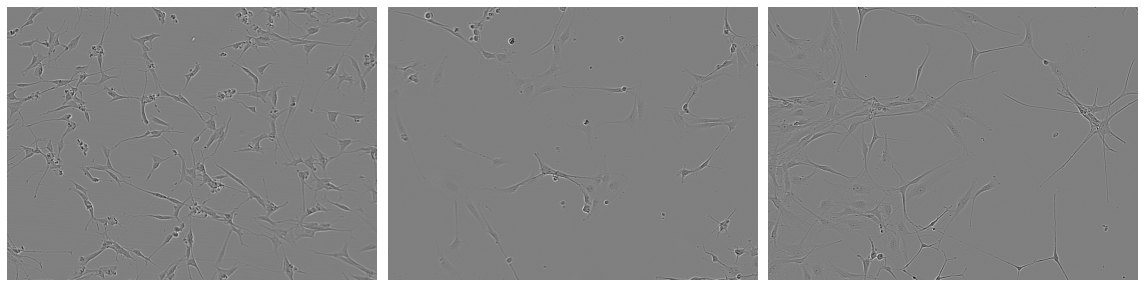

In [32]:
display_multiple_img(test_set,1,3)

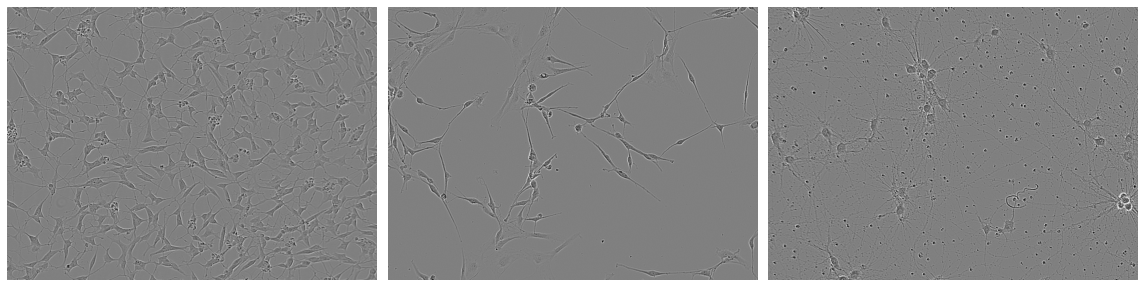

In [33]:
display_multiple_img(train_set,1,3)

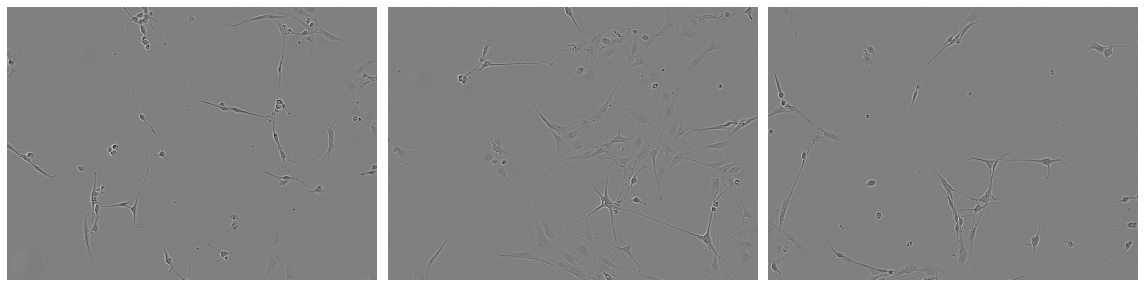

In [34]:
display_multiple_img(train_semi_set,1,3)

In [35]:
imageObject = im.open(r"C:\Users\liamf\OneDrive - Hogeschool Leiden\Documenten\Northpool\Image_Processing\sartorius-cell-instance-segmentation\train\ffdb3cc02eef.png");
imageObject.show();

In [36]:
sharpened1 = imageObject.filter(ImageFilter.SHARPEN)
sharpened2 = sharpened1.filter(ImageFilter.SHARPEN)

In [37]:
# sharpened1.show()
# sharpened2.show()

In [38]:
def sharpen(image, aantal):
    imageObject = im.open(image)
    i = 0
    while i > aantal:
        imageObject = imageObject.filter(ImageFilter.SHARPEN)
        imageObject.show()
        i = i + 1
    return imageObject

In [39]:
testImg = plt.imread(r"C:\Users\liamf\OneDrive - Hogeschool Leiden\Documenten\Northpool\Image_Processing\sartorius-cell-instance-segmentation\train\ffdb3cc02eef.png")

In [40]:
testImg.shape

(520, 704)

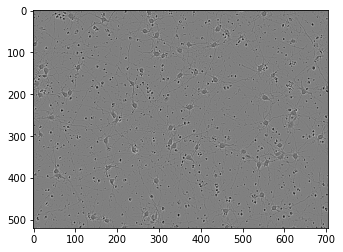

In [41]:
plt.imshow(testImg,cmap='gray')
plt.show()

In [42]:
# Hier maken we de twee kernels aan
Gx = np.matrix([[1,2,1],[0,0,0],[-1,-2,-1]])
Gy = np.matrix.transpose(Gx)
print(Gx)
print(Gy)

[[ 1  2  1]
 [ 0  0  0]
 [-1 -2 -1]]
[[ 1  0 -1]
 [ 2  0 -2]
 [ 1  0 -1]]


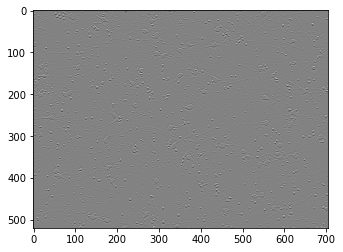

In [43]:
# Pas beide kernels toe in horinzontale en verticale richting
edgex = cv2.filter2D(testImg,-1,Gx)
edgey = cv2.filter2D(testImg,-1,Gy)
plt.imshow(edgex,cmap='gray')
plt.show()

In [44]:
# Neem de som van de kernels en daar de wortel uit. 
w = np.sqrt(np.square(edgex)+np.square(edgey))

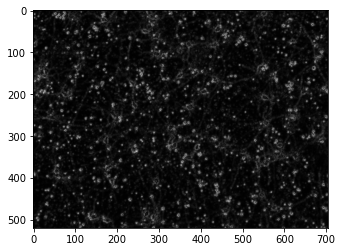

In [45]:
plt.imshow(w,cmap='gray')
plt.show()

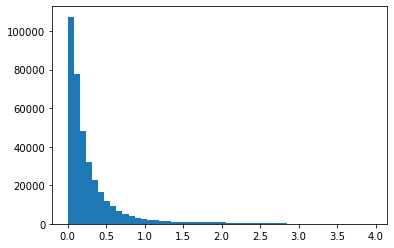

In [46]:
# Gebruik hier thresholding om de edges duidelijker te maken. 
plt.hist(w.flatten(),bins=50)
plt.show()

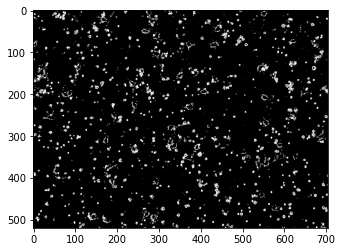

In [47]:
plt.imshow(w>1.0,cmap='gray')
plt.show()

In [140]:
testImg1 = r"C:\Users\liamf\OneDrive - Hogeschool Leiden\Documenten\Northpool\Image_Processing\sartorius-cell-instance-segmentation\train\0030fd0e6378.png"
testTrain = r"C:\Users\liamf\OneDrive - Hogeschool Leiden\Documenten\Northpool\Image_Processing\sartorius-cell-instance-segmentation\train"

(Text(0.5, 1.0, 'Edge Image'), ([], []), ([], []))

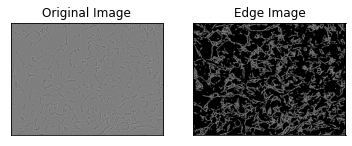

In [141]:
img = cv2.imread(testImg1,0)
edges = cv2.Canny(img,100,200)
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

In [142]:
edges = cv2.Canny(img, 100, 200)

row_indexes, col_indexes = np.nonzero(edges)

In [143]:
row_indexes

array([  0,   0,   0, ..., 519, 519, 519], dtype=int64)

In [144]:
col_indexes

array([  2,   3,   4, ..., 680, 688, 689], dtype=int64)

In [145]:
array = []

In [146]:
tel = 0
predict_mask = []
for i in row_indexes:
    predict_mask.append(i)
    predict_mask.append(col_indexes[tel])
    tel = tel + 1

0 2
0 3
0 4
0 5
0 9
0 21
0 22
0 25
0 29
0 31
0 32
0 36
0 37
0 39
0 64
0 66
0 70
0 71
0 74
0 89
0 90
0 93
0 94
0 103
0 154
0 159
0 164
0 167
0 169
0 196
0 197
0 246
0 248
0 251
0 254
0 255
0 256
0 257
0 258
0 260
0 266
0 269
0 270
0 271
0 275
0 278
0 283
0 286
0 287
0 290
0 300
0 302
0 312
0 314
0 318
0 321
0 322
0 329
0 331
0 333
0 334
0 336
0 340
0 342
0 343
0 360
0 361
0 364
0 538
0 539
0 540
0 541
0 552
0 554
0 617
0 619
0 621
0 622
0 625
0 643
0 650
0 652
0 654
0 659
0 683
1 1
1 2
1 4
1 10
1 15
1 22
1 23
1 26
1 27
1 30
1 31
1 37
1 38
1 39
1 40
1 41
1 65
1 66
1 71
1 72
1 73
1 74
1 88
1 89
1 92
1 93
1 101
1 102
1 103
1 104
1 106
1 152
1 154
1 159
1 164
1 166
1 169
1 195
1 196
1 244
1 246
1 248
1 252
1 254
1 260
1 266
1 268
1 269
1 275
1 278
1 282
1 283
1 285
1 287
1 288
1 289
1 293
1 294
1 295
1 296
1 297
1 300
1 302
1 310
1 311
1 312
1 313
1 314
1 316
1 317
1 320
1 327
1 329
1 330
1 331
1 336
1 337
1 339
1 342
1 359
1 363
1 364
1 407
1 408
1 472
1 542
1 552
1 554
1 615
1 617
1 618
1

17 641
17 644
17 646
17 671
17 674
17 675
17 678
17 689
17 691
18 32
18 33
18 34
18 35
18 36
18 42
18 43
18 53
18 97
18 98
18 105
18 106
18 107
18 108
18 109
18 110
18 111
18 117
18 118
18 119
18 120
18 125
18 126
18 127
18 132
18 133
18 141
18 142
18 143
18 146
18 150
18 151
18 159
18 161
18 172
18 173
18 204
18 205
18 206
18 207
18 208
18 215
18 216
18 223
18 226
18 239
18 240
18 241
18 242
18 243
18 244
18 245
18 250
18 251
18 253
18 257
18 258
18 261
18 262
18 263
18 302
18 303
18 350
18 361
18 362
18 365
18 366
18 367
18 375
18 379
18 380
18 394
18 479
18 499
18 500
18 507
18 508
18 509
18 510
18 529
18 530
18 534
18 535
18 536
18 539
18 542
18 544
18 545
18 546
18 555
18 559
18 561
18 563
18 564
18 567
18 578
18 579
18 582
18 586
18 589
18 595
18 597
18 598
18 600
18 622
18 624
18 638
18 639
18 643
18 644
18 646
18 672
18 675
18 676
18 679
18 686
18 688
18 689
18 691
19 37
19 43
19 53
19 55
19 93
19 96
19 111
19 112
19 113
19 114
19 115
19 122
19 123
19 124
19 145
19 159
19 161
1

38 403
38 405
38 407
38 417
38 420
38 534
38 536
38 550
38 553
38 554
38 615
38 619
38 620
38 621
38 624
38 626
38 627
38 632
38 633
38 634
38 638
38 640
38 641
38 644
38 650
38 651
38 654
38 683
38 690
38 693
38 694
38 698
38 701
39 0
39 1
39 2
39 4
39 36
39 49
39 51
39 64
39 65
39 89
39 91
39 105
39 106
39 109
39 110
39 113
39 114
39 122
39 132
39 137
39 138
39 139
39 140
39 150
39 158
39 160
39 165
39 167
39 169
39 172
39 245
39 246
39 256
39 268
39 269
39 270
39 271
39 272
39 291
39 292
39 293
39 294
39 295
39 296
39 297
39 298
39 299
39 300
39 301
39 302
39 303
39 304
39 305
39 306
39 307
39 308
39 309
39 310
39 311
39 312
39 313
39 314
39 315
39 316
39 325
39 326
39 327
39 336
39 394
39 403
39 405
39 407
39 419
39 420
39 534
39 536
39 550
39 552
39 616
39 617
39 622
39 625
39 629
39 630
39 631
39 638
39 641
39 642
39 645
39 648
39 650
39 653
39 654
39 655
39 656
39 657
39 658
39 662
39 682
39 683
39 691
39 694
39 695
39 697
40 4
40 19
40 20
40 21
40 22
40 30
40 31
40 49
40 51
40 

63 456
63 457
63 481
63 483
63 501
63 503
63 512
63 514
63 605
63 608
63 621
63 623
63 636
63 666
63 691
63 692
64 30
64 63
64 65
64 66
64 69
64 74
64 78
64 79
64 82
64 130
64 131
64 133
64 156
64 157
64 159
64 246
64 247
64 251
64 256
64 259
64 288
64 296
64 298
64 299
64 300
64 301
64 312
64 314
64 316
64 318
64 361
64 364
64 365
64 376
64 377
64 378
64 379
64 380
64 381
64 386
64 387
64 388
64 389
64 391
64 393
64 397
64 399
64 400
64 401
64 403
64 406
64 407
64 408
64 409
64 413
64 414
64 415
64 448
64 449
64 452
64 459
64 460
64 461
64 480
64 481
64 483
64 501
64 503
64 510
64 512
64 514
64 604
64 608
64 621
64 624
64 626
64 636
64 666
64 690
64 691
65 30
65 32
65 62
65 65
65 68
65 69
65 73
65 77
65 81
65 131
65 133
65 134
65 157
65 159
65 244
65 248
65 249
65 257
65 259
65 287
65 296
65 297
65 300
65 301
65 313
65 314
65 316
65 318
65 359
65 363
65 364
65 373
65 374
65 375
65 382
65 383
65 384
65 389
65 390
65 391
65 393
65 395
65 396
65 397
65 402
65 403
65 408
65 410
65 413
65 

88 157
88 171
88 172
88 175
88 176
88 250
88 252
88 258
88 328
88 329
88 332
88 333
88 339
88 340
88 341
88 343
88 356
88 359
88 360
88 366
88 368
88 371
88 372
88 451
88 462
88 464
88 466
88 469
88 470
88 471
88 473
88 475
88 482
88 484
88 490
88 532
88 539
88 564
88 602
88 603
88 607
88 611
88 612
88 613
88 614
88 615
88 616
88 617
88 624
88 628
88 629
88 630
88 637
88 638
88 639
88 640
88 641
88 642
88 643
88 644
88 645
88 653
88 654
88 655
88 670
88 671
88 681
88 683
88 684
88 686
88 691
88 694
89 9
89 11
89 19
89 23
89 70
89 71
89 80
89 84
89 85
89 92
89 93
89 94
89 95
89 116
89 117
89 121
89 122
89 126
89 127
89 129
89 130
89 131
89 146
89 150
89 151
89 173
89 176
89 177
89 250
89 252
89 258
89 260
89 326
89 333
89 339
89 355
89 358
89 359
89 362
89 366
89 368
89 371
89 398
89 452
89 453
89 454
89 462
89 463
89 464
89 466
89 473
89 475
89 482
89 484
89 490
89 531
89 538
89 539
89 561
89 562
89 564
89 565
89 567
89 600
89 601
89 603
89 605
89 606
89 607
89 609
89 611
89 625
89 626

114 387
114 388
114 394
114 402
114 404
114 413
114 414
114 415
114 416
114 417
114 425
114 426
114 433
114 434
114 451
114 554
114 555
114 556
114 560
114 561
114 596
114 600
114 664
114 672
115 12
115 87
115 89
115 112
115 116
115 117
115 120
115 121
115 223
115 225
115 233
115 234
115 239
115 241
115 296
115 297
115 302
115 303
115 306
115 311
115 350
115 352
115 363
115 364
115 365
115 370
115 373
115 385
115 389
115 390
115 394
115 395
115 401
115 404
115 417
115 422
115 423
115 424
115 425
115 428
115 429
115 434
115 436
115 452
115 479
115 488
115 489
115 557
115 562
115 563
115 564
115 594
115 595
115 599
115 664
115 672
116 12
116 40
116 87
116 89
116 119
116 223
116 225
116 227
116 230
116 231
116 238
116 297
116 298
116 299
116 303
116 304
116 307
116 310
116 313
116 350
116 352
116 360
116 361
116 362
116 363
116 365
116 366
116 367
116 370
116 373
116 383
116 386
116 387
116 390
116 391
116 392
116 395
116 396
116 401
116 403
116 415
116 417
116 418
116 419
116 421
116 428

129 540
129 546
129 547
129 548
129 549
129 550
129 582
129 585
129 592
129 669
129 671
129 675
129 678
129 692
129 693
129 696
129 697
129 700
130 16
130 18
130 21
130 87
130 89
130 90
130 91
130 107
130 112
130 147
130 225
130 226
130 231
130 232
130 233
130 234
130 235
130 243
130 244
130 248
130 252
130 281
130 284
130 285
130 290
130 292
130 296
130 299
130 303
130 304
130 311
130 312
130 313
130 319
130 320
130 321
130 348
130 351
130 359
130 364
130 393
130 396
130 406
130 437
130 439
130 441
130 472
130 487
130 489
130 512
130 513
130 517
130 519
130 521
130 523
130 537
130 538
130 539
130 542
130 543
130 544
130 550
130 551
130 583
130 585
130 592
130 593
130 669
130 671
130 672
130 675
130 678
130 694
130 695
130 699
131 16
131 18
131 19
131 21
131 22
131 87
131 90
131 112
131 147
131 148
131 209
131 210
131 211
131 220
131 224
131 225
131 228
131 232
131 235
131 236
131 244
131 246
131 249
131 250
131 253
131 280
131 283
131 284
131 288
131 289
131 290
131 292
131 293
131 29

155 188
155 193
155 265
155 267
155 269
155 270
155 273
155 304
155 330
155 333
155 350
155 351
155 352
155 353
155 354
155 403
155 424
155 431
155 432
155 434
155 435
155 456
155 457
155 460
155 461
155 464
155 466
155 468
155 481
155 482
155 484
155 504
155 550
155 551
155 554
155 555
155 563
155 565
155 566
155 617
155 621
155 677
155 678
155 687
155 688
155 693
156 28
156 31
156 36
156 81
156 84
156 86
156 115
156 117
156 119
156 126
156 129
156 130
156 134
156 135
156 136
156 139
156 141
156 190
156 191
156 194
156 261
156 264
156 266
156 267
156 269
156 302
156 304
156 305
156 329
156 330
156 332
156 333
156 354
156 390
156 403
156 406
156 422
156 423
156 424
156 439
156 462
156 464
156 466
156 468
156 484
156 504
156 505
156 562
156 563
156 565
156 568
156 616
156 619
156 620
156 621
156 622
156 623
156 678
156 688
156 693
157 28
157 36
157 37
157 84
157 86
157 115
157 117
157 119
157 127
157 129
157 132
157 133
157 139
157 142
157 190
157 192
157 195
157 261
157 264
157 266
157

176 18
176 21
176 52
176 53
176 78
176 83
176 85
176 93
176 96
176 102
176 103
176 104
176 113
176 115
176 116
176 117
176 122
176 124
176 126
176 132
176 135
176 198
176 201
176 202
176 205
176 206
176 208
176 209
176 215
176 217
176 219
176 242
176 243
176 254
176 256
176 266
176 271
176 275
176 282
176 299
176 300
176 301
176 302
176 303
176 304
176 305
176 306
176 307
176 308
176 309
176 332
176 333
176 338
176 378
176 380
176 411
176 416
176 417
176 418
176 420
176 421
176 424
176 425
176 426
176 430
176 431
176 432
176 433
176 452
176 468
176 470
176 472
176 474
176 475
176 509
176 584
176 585
176 586
176 631
176 634
176 639
176 640
176 644
176 655
177 3
177 16
177 17
177 20
177 48
177 49
177 50
177 53
177 54
177 57
177 83
177 85
177 94
177 96
177 108
177 113
177 119
177 120
177 125
177 126
177 133
177 136
177 137
177 199
177 202
177 203
177 206
177 209
177 210
177 215
177 217
177 219
177 242
177 243
177 244
177 245
177 254
177 256
177 260
177 261
177 262
177 263
177 266
177 270


186 410
186 419
186 423
186 424
186 425
186 428
186 430
186 432
186 449
186 458
186 459
186 464
186 471
186 538
186 565
186 566
186 570
186 571
186 572
186 578
186 586
186 598
186 599
186 610
186 611
186 615
186 616
186 617
186 627
186 628
186 629
186 632
186 635
186 636
186 637
186 638
186 640
186 641
186 646
186 660
186 661
186 664
186 677
186 678
186 679
187 46
187 47
187 49
187 50
187 51
187 67
187 70
187 71
187 72
187 101
187 102
187 103
187 104
187 110
187 111
187 112
187 114
187 117
187 168
187 172
187 184
187 191
187 192
187 193
187 194
187 195
187 196
187 198
187 199
187 200
187 201
187 202
187 203
187 204
187 205
187 207
187 210
187 221
187 250
187 252
187 266
187 268
187 271
187 272
187 276
187 277
187 279
187 280
187 282
187 283
187 284
187 287
187 291
187 309
187 310
187 311
187 314
187 315
187 316
187 327
187 329
187 330
187 331
187 333
187 337
187 345
187 389
187 399
187 400
187 407
187 408
187 410
187 411
187 418
187 421
187 425
187 426
187 428
187 430
187 432
187 433
1

208 296
208 301
208 302
208 303
208 331
208 333
208 348
208 352
208 389
208 397
208 399
208 400
208 401
208 403
208 405
208 408
208 409
208 411
208 424
208 427
208 428
208 429
208 430
208 440
208 442
208 443
208 444
208 445
208 446
208 447
208 448
208 456
208 457
208 460
208 463
208 464
208 466
208 467
208 473
208 478
208 480
208 502
208 503
208 504
208 505
208 507
208 509
208 510
208 511
208 513
208 514
208 515
208 516
208 521
208 522
208 537
208 538
208 539
208 542
208 543
208 567
208 568
208 581
208 628
208 637
208 638
208 639
208 640
208 641
208 642
208 643
208 644
208 649
208 650
208 699
209 8
209 59
209 75
209 77
209 82
209 84
209 90
209 92
209 94
209 96
209 110
209 111
209 115
209 116
209 133
209 134
209 135
209 154
209 155
209 180
209 181
209 182
209 186
209 187
209 205
209 206
209 221
209 227
209 271
209 273
209 280
209 283
209 284
209 288
209 289
209 290
209 291
209 292
209 297
209 298
209 299
209 306
209 307
209 308
209 309
209 310
209 311
209 312
209 313
209 314
209 315
209

218 305
218 330
218 332
218 333
218 334
218 335
218 339
218 357
218 359
218 360
218 382
218 386
218 390
218 397
218 399
218 438
218 440
218 510
218 518
218 521
218 524
218 525
218 528
218 536
218 539
218 540
218 541
218 542
218 544
218 545
218 551
218 572
218 585
218 587
218 589
218 623
218 625
218 626
218 629
218 630
218 631
218 632
218 633
218 634
218 635
218 636
218 637
218 640
218 643
218 685
219 2
219 4
219 5
219 10
219 12
219 14
219 32
219 33
219 34
219 78
219 80
219 96
219 99
219 100
219 114
219 116
219 120
219 123
219 125
219 136
219 137
219 138
219 139
219 140
219 141
219 142
219 143
219 144
219 151
219 152
219 153
219 154
219 163
219 164
219 165
219 166
219 169
219 175
219 177
219 230
219 232
219 233
219 267
219 271
219 306
219 307
219 308
219 309
219 310
219 319
219 320
219 321
219 322
219 323
219 327
219 328
219 330
219 336
219 337
219 340
219 341
219 358
219 360
219 386
219 389
219 390
219 391
219 392
219 393
219 394
219 395
219 396
219 397
219 399
219 437
219 440
219 511


231 331
231 332
231 380
231 385
231 387
231 391
231 394
231 396
231 420
231 421
231 427
231 429
231 433
231 435
231 449
231 452
231 517
231 520
231 552
231 553
231 571
231 572
231 576
231 579
231 580
231 584
231 588
231 589
231 593
231 594
231 616
231 617
231 619
231 633
231 634
231 635
231 638
231 644
231 645
231 647
231 648
231 651
231 652
231 664
231 665
231 668
231 669
231 670
231 671
231 672
231 676
231 678
231 680
231 697
231 698
231 701
232 4
232 5
232 6
232 11
232 12
232 15
232 16
232 17
232 19
232 78
232 79
232 82
232 106
232 108
232 118
232 119
232 120
232 166
232 169
232 229
232 234
232 274
232 326
232 330
232 385
232 387
232 391
232 393
232 394
232 396
232 419
232 423
232 427
232 433
232 435
232 449
232 452
232 519
232 554
232 555
232 568
232 571
232 577
232 578
232 582
232 583
232 590
232 591
232 593
232 594
232 610
232 611
232 614
232 615
232 619
232 635
232 637
232 638
232 639
232 640
232 642
232 645
232 649
232 651
232 653
232 661
232 665
232 676
232 678
232 680
232 695

255 501
255 502
255 513
255 514
255 557
255 597
255 598
255 599
255 600
255 601
255 602
255 609
255 610
255 647
255 648
255 651
255 652
255 660
255 665
255 666
255 667
255 668
255 669
256 0
256 5
256 6
256 7
256 10
256 11
256 12
256 13
256 17
256 19
256 20
256 21
256 22
256 23
256 24
256 25
256 26
256 38
256 39
256 43
256 44
256 72
256 73
256 74
256 80
256 81
256 83
256 85
256 126
256 157
256 163
256 164
256 181
256 183
256 185
256 189
256 191
256 193
256 197
256 198
256 233
256 235
256 267
256 268
256 269
256 283
256 284
256 302
256 304
256 337
256 346
256 347
256 349
256 351
256 382
256 387
256 388
256 390
256 396
256 398
256 415
256 462
256 464
256 467
256 468
256 469
256 499
256 502
256 512
256 513
256 516
256 557
256 559
256 604
256 605
256 606
256 608
256 609
256 650
256 651
256 660
256 662
256 663
256 664
257 0
257 1
257 2
257 3
257 4
257 6
257 9
257 15
257 17
257 19
257 40
257 72
257 74
257 78
257 79
257 80
257 82
257 85
257 126
257 157
257 164
257 172
257 173
257 174
257 175
2

276 258
276 259
276 263
276 264
276 270
276 271
276 272
276 273
276 274
276 275
276 285
276 289
276 290
276 314
276 315
276 332
276 333
276 339
276 341
276 367
276 370
276 403
276 404
276 405
276 410
276 413
276 415
276 416
276 418
276 420
276 440
276 444
276 445
276 446
276 447
276 450
276 451
276 453
276 454
276 456
276 470
276 497
276 498
276 512
276 536
276 537
276 587
276 590
276 592
276 610
276 611
276 662
276 665
276 680
276 681
276 682
276 685
277 13
277 15
277 17
277 28
277 31
277 64
277 76
277 78
277 79
277 81
277 85
277 108
277 111
277 147
277 151
277 152
277 153
277 154
277 156
277 159
277 178
277 231
277 250
277 260
277 261
277 262
277 276
277 277
277 278
277 279
277 280
277 281
277 282
277 283
277 284
277 285
277 286
277 287
277 316
277 333
277 339
277 341
277 367
277 368
277 410
277 414
277 418
277 420
277 450
277 453
277 455
277 459
277 462
277 496
277 497
277 504
277 505
277 506
277 507
277 508
277 509
277 510
277 512
277 513
277 535
277 552
277 558
277 559
277 560
277

297 482
297 485
297 486
297 489
297 490
297 536
297 537
297 538
297 539
297 542
297 543
297 544
297 545
297 546
297 548
297 550
297 551
297 552
297 553
297 559
297 560
297 561
297 584
297 603
297 604
297 680
297 683
297 687
297 688
297 689
297 701
297 702
298 14
298 16
298 17
298 21
298 22
298 25
298 28
298 30
298 31
298 35
298 39
298 43
298 44
298 46
298 82
298 143
298 146
298 161
298 165
298 166
298 177
298 183
298 184
298 185
298 186
298 189
298 212
298 213
298 214
298 217
298 218
298 219
298 232
298 249
298 250
298 251
298 252
298 308
298 321
298 322
298 340
298 341
298 342
298 344
298 345
298 346
298 347
298 348
298 350
298 351
298 352
298 354
298 355
298 357
298 360
298 361
298 362
298 366
298 369
298 370
298 371
298 375
298 409
298 410
298 415
298 417
298 419
298 476
298 479
298 480
298 481
298 486
298 487
298 488
298 491
298 492
298 493
298 541
298 546
298 547
298 552
298 558
298 584
298 602
298 603
298 680
298 683
298 684
298 685
298 686
298 687
298 698
298 699
298 700
299 14


326 402
326 403
326 404
326 410
326 411
326 412
326 413
326 414
326 418
326 437
326 451
326 452
326 456
326 457
326 458
326 459
326 504
326 508
326 509
326 520
326 527
326 529
326 530
326 532
326 552
326 572
326 577
326 579
326 580
326 581
326 602
326 603
326 604
326 605
326 612
326 643
326 644
326 647
326 648
326 676
326 677
326 686
327 68
327 103
327 104
327 110
327 161
327 162
327 163
327 164
327 172
327 173
327 175
327 178
327 180
327 227
327 229
327 256
327 257
327 258
327 270
327 276
327 277
327 278
327 283
327 284
327 314
327 317
327 319
327 330
327 332
327 333
327 353
327 355
327 415
327 416
327 437
327 450
327 453
327 454
327 455
327 457
327 480
327 481
327 482
327 483
327 503
327 506
327 507
327 508
327 518
327 519
327 520
327 528
327 529
327 531
327 552
327 569
327 570
327 571
327 572
327 574
327 577
327 579
327 583
327 602
327 605
327 606
327 611
327 612
327 618
327 619
327 620
327 621
327 622
327 623
327 624
327 625
327 626
327 634
327 635
327 645
327 646
327 676
327 685
3

344 609
344 610
344 616
344 618
344 619
344 621
344 622
344 637
344 640
345 74
345 75
345 76
345 79
345 82
345 83
345 84
345 87
345 96
345 97
345 98
345 104
345 105
345 106
345 140
345 141
345 143
345 166
345 167
345 170
345 173
345 231
345 232
345 233
345 237
345 238
345 239
345 245
345 246
345 247
345 327
345 329
345 333
345 335
345 342
345 346
345 349
345 350
345 351
345 352
345 353
345 372
345 375
345 380
345 383
345 384
345 387
345 388
345 389
345 405
345 406
345 407
345 411
345 442
345 445
345 449
345 450
345 451
345 454
345 488
345 489
345 490
345 491
345 492
345 493
345 494
345 495
345 496
345 497
345 509
345 510
345 511
345 512
345 513
345 514
345 528
345 529
345 530
345 538
345 539
345 540
345 545
345 546
345 547
345 558
345 567
345 568
345 569
345 573
345 574
345 579
345 599
345 600
345 602
345 603
345 604
345 605
345 606
345 608
345 609
345 611
345 613
345 614
345 619
345 621
345 623
345 636
345 639
345 640
346 77
346 79
346 80
346 84
346 87
346 90
346 91
346 92
346 93
346 

361 334
361 337
361 338
361 340
361 364
361 366
361 367
361 370
361 371
361 395
361 399
361 400
361 402
361 403
361 420
361 422
361 424
361 440
361 441
361 446
361 451
361 453
361 454
361 455
361 458
361 462
361 465
361 508
361 509
361 514
361 515
361 522
361 524
361 526
361 527
361 551
361 552
361 553
361 554
361 580
361 627
361 629
361 631
361 667
361 668
361 685
361 693
362 74
362 77
362 131
362 138
362 140
362 205
362 208
362 209
362 210
362 211
362 212
362 243
362 244
362 245
362 262
362 263
362 267
362 271
362 272
362 282
362 283
362 292
362 293
362 294
362 332
362 333
362 336
362 338
362 363
362 366
362 400
362 403
362 404
362 420
362 422
362 425
362 440
362 446
362 448
362 449
362 450
362 453
362 458
362 464
362 465
362 503
362 504
362 506
362 507
362 513
362 517
362 522
362 523
362 524
362 554
362 555
362 579
362 629
362 631
362 683
362 684
362 686
362 687
363 74
363 76
363 77
363 130
363 132
363 134
363 138
363 204
363 241
363 243
363 245
363 263
363 264
363 265
363 266
363 2

384 27
384 28
384 54
384 56
384 57
384 65
384 67
384 127
384 136
384 138
384 139
384 145
384 148
384 149
384 150
384 155
384 157
384 164
384 166
384 172
384 173
384 175
384 178
384 179
384 189
384 190
384 199
384 200
384 201
384 202
384 204
384 209
384 210
384 213
384 230
384 234
384 235
384 236
384 240
384 241
384 251
384 252
384 256
384 257
384 258
384 264
384 268
384 269
384 270
384 325
384 331
384 333
384 386
384 388
384 436
384 437
384 438
384 439
384 453
384 454
384 457
384 458
384 460
384 463
384 477
384 478
384 479
384 480
384 502
384 506
384 507
384 514
384 515
384 519
384 534
384 544
384 545
384 555
384 568
384 569
384 617
384 618
384 624
384 625
384 629
384 632
384 644
384 645
384 646
384 647
384 648
384 663
384 667
384 668
384 669
384 678
384 679
384 682
384 683
384 684
384 685
385 24
385 25
385 26
385 29
385 30
385 53
385 56
385 61
385 62
385 64
385 128
385 129
385 138
385 142
385 143
385 147
385 148
385 157
385 164
385 165
385 166
385 168
385 169
385 171
385 172
385 175
3

402 559
402 573
402 574
402 575
402 584
402 585
402 586
402 587
402 589
402 616
402 623
402 640
402 643
402 650
402 651
402 662
402 665
402 666
402 667
402 669
402 670
402 673
402 674
403 47
403 50
403 51
403 59
403 61
403 88
403 89
403 110
403 112
403 113
403 117
403 118
403 119
403 137
403 144
403 167
403 174
403 185
403 186
403 202
403 203
403 204
403 239
403 241
403 243
403 245
403 246
403 249
403 253
403 254
403 259
403 260
403 261
403 267
403 269
403 284
403 287
403 289
403 321
403 323
403 325
403 327
403 329
403 331
403 333
403 347
403 350
403 351
403 352
403 353
403 356
403 359
403 370
403 373
403 374
403 376
403 381
403 384
403 394
403 397
403 442
403 444
403 448
403 468
403 469
403 470
403 480
403 486
403 487
403 490
403 491
403 528
403 530
403 531
403 536
403 537
403 538
403 556
403 559
403 571
403 572
403 573
403 583
403 584
403 587
403 589
403 590
403 616
403 640
403 642
403 643
403 645
403 646
403 647
403 648
403 649
403 650
403 653
403 654
403 661
403 664
403 670
403 671

421 560
421 565
421 567
421 573
421 576
421 581
421 584
421 589
421 593
421 596
421 598
421 599
421 600
421 601
421 602
421 603
421 604
421 607
421 608
421 629
421 692
421 693
421 697
421 698
421 699
421 700
422 14
422 23
422 88
422 90
422 97
422 99
422 101
422 102
422 106
422 107
422 111
422 112
422 113
422 114
422 115
422 116
422 119
422 131
422 134
422 140
422 142
422 147
422 151
422 152
422 153
422 177
422 179
422 196
422 198
422 200
422 201
422 202
422 203
422 204
422 205
422 214
422 218
422 219
422 220
422 221
422 235
422 236
422 237
422 242
422 243
422 244
422 245
422 292
422 295
422 300
422 320
422 340
422 348
422 354
422 355
422 358
422 361
422 369
422 372
422 373
422 375
422 408
422 415
422 417
422 427
422 429
422 430
422 433
422 435
422 437
422 457
422 458
422 459
422 464
422 465
422 473
422 528
422 532
422 534
422 541
422 550
422 551
422 552
422 553
422 558
422 560
422 565
422 567
422 569
422 572
422 573
422 581
422 584
422 589
422 594
422 596
422 606
422 607
422 626
422 62

438 475
438 476
438 477
438 478
438 479
438 480
438 485
438 486
438 487
438 488
438 490
438 497
438 498
438 511
438 512
438 520
438 521
438 534
438 545
438 546
438 574
438 601
438 602
438 617
438 618
438 619
438 620
438 626
438 627
438 639
438 640
438 641
438 642
438 643
438 645
438 664
438 667
439 40
439 42
439 43
439 46
439 51
439 58
439 78
439 80
439 84
439 89
439 90
439 105
439 107
439 119
439 122
439 123
439 125
439 128
439 129
439 165
439 166
439 175
439 176
439 180
439 181
439 182
439 183
439 223
439 224
439 226
439 235
439 242
439 244
439 281
439 284
439 290
439 292
439 295
439 300
439 301
439 328
439 329
439 330
439 332
439 353
439 365
439 404
439 405
439 406
439 407
439 412
439 424
439 426
439 429
439 436
439 439
439 443
439 448
439 449
439 450
439 455
439 457
439 458
439 465
439 466
439 467
439 468
439 469
439 470
439 490
439 494
439 495
439 498
439 499
439 500
439 501
439 502
439 503
439 504
439 505
439 506
439 507
439 508
439 509
439 510
439 514
439 515
439 516
439 519
439

448 536
448 537
448 538
448 541
448 543
448 544
448 545
448 547
448 563
448 564
448 566
448 574
448 638
448 639
448 640
448 651
448 652
448 663
448 664
448 665
448 666
448 667
448 673
448 674
448 675
448 682
448 685
448 688
448 693
448 697
448 698
449 46
449 61
449 64
449 78
449 80
449 110
449 111
449 121
449 122
449 123
449 148
449 149
449 150
449 151
449 152
449 154
449 156
449 157
449 158
449 159
449 166
449 207
449 208
449 242
449 245
449 246
449 281
449 283
449 284
449 294
449 300
449 301
449 306
449 308
449 309
449 352
449 363
449 365
449 368
449 369
449 370
449 371
449 372
449 374
449 375
449 388
449 389
449 390
449 402
449 404
449 410
449 412
449 415
449 418
449 419
449 420
449 421
449 424
449 435
449 436
449 438
449 439
449 440
449 443
449 445
449 448
449 450
449 476
449 477
449 478
449 479
449 481
449 482
449 493
449 495
449 534
449 538
449 540
449 545
449 546
449 547
449 564
449 567
449 574
449 649
449 650
449 680
449 682
449 683
449 684
449 685
449 687
449 689
449 690
449 6

459 577
459 581
459 593
459 596
459 600
459 601
459 602
459 603
459 604
459 605
459 645
459 672
459 675
459 688
459 689
459 690
459 697
459 699
460 55
460 56
460 57
460 60
460 84
460 103
460 104
460 105
460 106
460 107
460 110
460 112
460 116
460 118
460 128
460 131
460 148
460 150
460 162
460 191
460 194
460 218
460 239
460 242
460 291
460 294
460 313
460 314
460 315
460 336
460 337
460 338
460 339
460 346
460 348
460 353
460 354
460 355
460 362
460 369
460 370
460 371
460 373
460 376
460 377
460 378
460 382
460 383
460 384
460 387
460 402
460 404
460 408
460 419
460 420
460 425
460 426
460 427
460 434
460 436
460 441
460 445
460 451
460 461
460 462
460 484
460 487
460 488
460 489
460 490
460 507
460 510
460 511
460 512
460 516
460 517
460 518
460 523
460 534
460 537
460 543
460 567
460 568
460 569
460 570
460 571
460 575
460 578
460 579
460 580
460 581
460 586
460 587
460 588
460 589
460 590
460 591
460 592
460 645
460 673
460 675
460 691
460 697
460 700
461 59
461 84
461 101
461 102

481 223
481 225
481 227
481 243
481 244
481 247
481 251
481 252
481 253
481 272
481 286
481 288
481 289
481 306
481 309
481 350
481 352
481 384
481 387
481 388
481 398
481 399
481 400
481 401
481 403
481 406
481 411
481 432
481 433
481 436
481 437
481 438
481 442
481 443
481 444
481 447
481 455
481 456
481 464
481 465
481 466
481 471
481 472
481 475
481 484
481 485
481 488
481 499
481 501
481 533
481 534
481 543
481 544
481 545
481 546
481 548
481 560
481 561
481 562
481 563
481 568
481 569
481 570
481 571
481 593
481 594
481 612
481 613
481 615
481 616
481 623
481 624
481 625
481 626
481 629
481 630
481 631
481 655
481 656
481 700
481 701
481 702
481 703
482 63
482 64
482 78
482 79
482 109
482 111
482 121
482 125
482 126
482 134
482 159
482 161
482 167
482 169
482 202
482 203
482 204
482 205
482 206
482 207
482 208
482 209
482 210
482 223
482 225
482 227
482 243
482 246
482 248
482 249
482 250
482 254
482 255
482 256
482 271
482 289
482 306
482 307
482 309
482 348
482 349
482 351
482 

495 125
495 126
495 130
495 131
495 138
495 143
495 144
495 145
495 158
495 161
495 162
495 224
495 226
495 241
495 243
495 261
495 263
495 283
495 285
495 301
495 302
495 303
495 304
495 305
495 306
495 307
495 308
495 309
495 310
495 311
495 312
495 325
495 380
495 383
495 420
495 421
495 424
495 425
495 431
495 434
495 435
495 438
495 448
495 449
495 458
495 459
495 463
495 485
495 486
495 492
495 496
495 498
495 503
495 505
495 506
495 517
495 521
495 522
495 523
495 524
495 525
495 526
495 533
495 538
495 546
495 547
495 558
495 559
495 560
495 561
495 562
495 563
495 564
495 565
495 566
495 567
495 568
495 569
495 580
495 695
495 699
495 700
495 702
496 0
496 1
496 15
496 16
496 22
496 27
496 28
496 29
496 32
496 38
496 39
496 40
496 41
496 47
496 48
496 50
496 60
496 63
496 64
496 75
496 106
496 107
496 108
496 109
496 110
496 114
496 115
496 116
496 117
496 118
496 121
496 122
496 124
496 128
496 129
496 146
496 157
496 158
496 160
496 161
496 180
496 224
496 243
496 261
496 26

In [148]:
image_array= []
a = []
groote = 519
i = 0
while i <= 519:
    a = []
    image_array.append(a)
    i = i +1

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],


In [149]:
i = 0
while i <= 519:
    o = 0
    while o <= 703:
        a = []
        image_array[i].append(a)
        o = o+1
    i = i +1

[[[],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  []

In [150]:
for i in image_array:
    for r in i:
            r.append(0.)
            r.append(0.)
            r.append(0.)

In [151]:
getal = 519
i= 0
lengte = len(predict_mask)
lengte = lengte - 1
while i <= lengte:
    rij = predict_mask[i]
    kolom = predict_mask[i+1]
    image_array[rij][kolom].clear()
    image_array[rij][kolom].append(1.)
    image_array[rij][kolom].append(1.)
    image_array[rij][kolom].append(1.)
    i = i + 2

In [152]:
image_array = np.array(image_array)

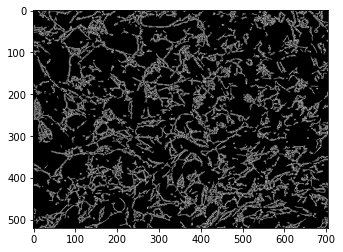

In [153]:
image_array = np.reshape(image_array, (520,704,-1))
plt.imshow(image_array)
plt.show()

In [91]:
def decode_rle_to_mask(rle, height, width, viz=False):
    '''
    rle : run-length as string formated (start value, count)
    height : height of the mask 
    width : width of the mask
    returns binary mask
    '''
    rle = np.array(rle.split(' ')).reshape(-1, 2)
    mask = np.zeros((height*width, 1, 3))
    if viz:
        color = np.random.rand(3)
    else:
        color = [1,1,1]
    for i in rle:
        mask[int(i[0]):int(i[0])+int(i[1]), :, :] = color

    return mask.reshape(height, width, 3)

In [92]:
example_id = "0030fd0e6378.png" # change the example id for different images
example_id2 = "0030fd0e6378"

[[[127 127 127]
  [127 127 127]
  [129 129 129]
  ...
  [129 129 129]
  [127 127 127]
  [128 128 128]]

 [[125 125 125]
  [128 128 128]
  [127 127 127]
  ...
  [132 132 132]
  [126 126 126]
  [126 126 126]]

 [[126 126 126]
  [128 128 128]
  [130 130 130]
  ...
  [129 129 129]
  [130 130 130]
  [131 131 131]]

 ...

 [[130 130 130]
  [131 131 131]
  [129 129 129]
  ...
  [115 115 115]
  [117 117 117]
  [137 137 137]]

 [[129 129 129]
  [129 129 129]
  [128 128 128]
  ...
  [128 128 128]
  [118 118 118]
  [125 125 125]]

 [[128 128 128]
  [128 128 128]
  [128 128 128]
  ...
  [142 142 142]
  [128 128 128]
  [121 121 121]]]
(520, 704, 3)
This is the image we are going to use, id:- C:\Users\liamf\OneDrive - Hogeschool Leiden\Documenten\Northpool\Image_Processing\sartorius-cell-instance-segmentation\train\ffdb3cc02eef.png


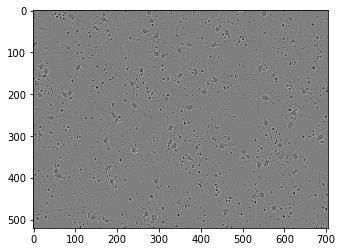

In [93]:
example_id = testImg1 # change the example id for different images
image = cv2.imread(os.path.join(train_set_raw,example_id))
print(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = (image-np.min(image))/(np.max(image)-np.min(image))
print(image.shape)
print("This is the image we are going to use, id:-", example_id)
plt.imshow(image)
plt.show()

The Annotation :  118145 6 118849 7 119553 8 120257 8 120961 9 121665 10 122369 12 123074 13 123778 14 124482 15 125186 16 125890 17 126594 18 127298 19 128002 20 128706 21 129410 22 130114 23 130818 24 131523 24 132227 25 132931 25 133635 24 134339 24 135043 23 135748 21 136452 19 137157 16 137864 11 138573 4
Now let's convert it to mask and view it
520 704


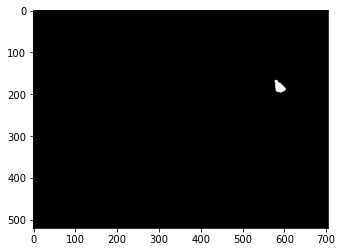

In [155]:
example_annot = df[df.id==example_id2].annotation.values[0]
print("The Annotation : ",example_annot)
print("Now let's convert it to mask and view it")
mask = decode_rle_to_mask(example_annot, image.shape[0], image.shape[1], viz=False)
print(image.shape[0], image.shape[1],)
plt.imshow(mask)
plt.show()

In [95]:
mask

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

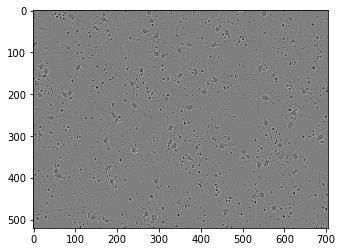

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


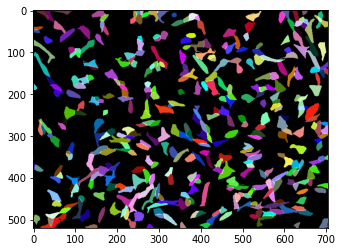

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


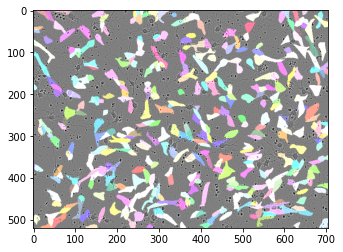

In [156]:
example_id_annotations = df[df.id==example_id2].annotation.values
masks = np.zeros(image.shape)
for each_cell_annot in example_id_annotations:
    mask = decode_rle_to_mask(each_cell_annot, image.shape[0], image.shape[1], viz=True)
    masks+=mask

plt.imshow(image)
plt.show()
plt.imshow(masks)
plt.show()
t = image+masks
plt.imshow(t)
plt.show()

In [157]:
masks

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0

In [ ]:
def run_length_decoding(compressed_seq):
  seq = ''
  for i in range(0,len(compressed_seq)):
    if compressed_seq[i].isalpha() == True:
      for j in range(int(compressed_seq[i+1])):
        seq += compressed_seq[i]
 
  return(seq)

In [ ]:
run_length_decoding(example_annot)

In [ ]:
array = row_indexes,col_indexes

In [ ]:
def encode_mask_to_rle(mask):
    '''
    mask: numpy array binary mask 
    1 - mask 
    0 - background
    Returns encoded run length 
    '''
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
def run_length_encoding(seq):
  compressed = []
  count = 1
  char = seq[0]
  for i in range(1,len(seq)):
    if seq[i] == char:
      count = count + 1
    else :
      compressed.append([char,count])
      char = seq[i]
      count = 1
  compressed.append([char,count])
  return compressed

In [ ]:
def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height, width, channels) of array to return
    color: color for the mask
    Returns numpy array (mask)

    '''
    s = mask_rle.split()

    starts = list(map(lambda x: int(x) - 1, s[0::2]))
    lengths = list(map(int, s[1::2]))
    ends = [x + y for x, y in zip(starts, lengths)]
    if len(shape)==3:
        img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)
    else:
        img = np.zeros(shape[0] * shape[1], dtype=np.float32)
    for start, end in zip(starts, ends):
        img[start : end] = color

    return img.reshape(shape)

In [ ]:
def rle_encoding(x):
    dots = np.where(x.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join(map(str, run_lengths))